In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [16]:
import sys

sys.path.append("/home/dchen/BA_CH_EN/")


import os

os.environ[
    "CUDA_VISIBLE_DEVICES"
] = "-1"  # this line tells TensorFlow not to use any GPU
# Basics
import tensorflow as tf
import xarray as xr
import pandas as pd

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores
from src.models.U_net.unet import Unet
from src.models.U_net.u_net_tests_params import *
from src.models.U_net.unet import *
from src.models.U_net.u_net_predict_evaluate import *

<IPython.core.display.Javascript object>

### 0. Set Up

In [10]:
lead_time = 0
var_num = 5

land_sea_mask_dummy = np.load(
    "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
)
land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 357, axis=0)

# load data
test_var_mean = []
test_var_std = []
test_var_y = []
for var in range(6):
    (
        padded_test_data_mean,
        padded_test_data_std,
        padded_test_data_y,
    ) = u_net_load_test_data(var, lead_time)
    test_var_mean.append(padded_test_data_mean)
    test_var_std.append(padded_test_data_std)
    test_var_y.append(padded_test_data_y)

# Then, pack all of your input data into a list
test_inputs = test_var_mean + test_var_std + [land_sea_mask_dummy]

test_target = test_var_y[var_num]

<IPython.core.display.Javascript object>

In [3]:
def plot_losses(csv_filepath, starting_epoch=0, ending_epoch=1000000000):
    # Load the csv file into a pandas DataFrame
    data = pd.read_csv(csv_filepath).iloc[starting_epoch:ending_epoch]

    # Create a new figure
    plt.figure(figsize=(10, 5))

    # Plot the training loss
    plt.plot(data["epoch"], data["loss"], label="Train Loss")

    # Plot the validation loss
    plt.plot(data["epoch"], data["val_loss"], label="Validation Loss")

    # Set the labels for the x and y axes
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Set the title for the plot
    plt.title("Training and Validation Loss")

    # Enable the legend
    plt.legend()

    # Display the plot
    plt.show()
    return data

<IPython.core.display.Javascript object>

In [26]:
def test_best_model(path, var_num, lead_time):

    model = tf.keras.models.load_model(
        path,
        custom_objects={
            "crps_cost_function_U": crps_cost_function_U,
            "crps_cost_function_trunc_U": crps_cost_function_trunc_U,
            "CustomSchedule": CustomSchedule,
        },
    )
    # load land_sea_mask
    land_sea_mask_dummy = np.load(
        "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
    )
    land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
    land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 357, axis=0)
    # load data
    test_var_mean = []
    test_var_std = []
    test_var_y = []
    for var in range(6):
        (
            padded_test_data_mean,
            padded_test_data_std,
            padded_test_data_y,
        ) = u_net_load_test_data(var, lead_time)
        test_var_mean.append(padded_test_data_mean)
        test_var_std.append(padded_test_data_std)
        test_var_y.append(padded_test_data_y)

    # Then, pack all of your input data into a list
    test_inputs = test_var_mean + test_var_std + [land_sea_mask_dummy]

    test_target = test_var_y[var_num]
    test_target_unpad = unpad_images_y(test_target)

    preds = model.predict(test_inputs, verbose=1)
    predictions_unpad = unpad_images(preds)
    if var_num in [5]:
        crps = crps_trunc
    else:
        crps = crps_normal

    scores = crps(
        mu=predictions_unpad[:, :, :, 0].flatten(),
        sigma=predictions_unpad[:, :, :, 1].flatten(),
        y=test_target_unpad.flatten(),
    )
    scores = scores.reshape((357, 120, 130)).mean(axis=0)
    return predictions_unpad, scores

<IPython.core.display.Javascript object>

In [34]:
def train_best_model(path, var_num, lead_time):

    model = tf.keras.models.load_model(
        path,
        custom_objects={
            "crps_cost_function_U": crps_cost_function_U,
            "crps_cost_function_trunc_U": crps_cost_function_trunc_U,
            "CustomSchedule": CustomSchedule,
        },
    )
    # load land_sea_mask
    land_sea_mask_dummy = np.load(
        "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
    )
    land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
    land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 1429, axis=0)
    # load data
    train_var_mean = []
    train_var_std = []
    train_var_y = []
    for var in range(6):
        (
            padded_train_data_mean,
            padded_train_data_std,
            padded_train_data_y,
        ) = u_net_load_train_data(var, lead_time)
        train_var_mean.append(padded_train_data_mean)
        train_var_std.append(padded_train_data_std)
        train_var_y.append(padded_train_data_y)

    # Then, pack all of your input data into a list
    train_inputs = train_var_mean + train_var_std + [land_sea_mask_dummy]

    train_target = train_var_y[var_num]
    train_target_unpad = unpad_images_y(train_target)

    preds = model.predict(train_inputs, verbose=1)
    predictions_unpad = unpad_images(preds)
    if var_num in [5]:
        crps = crps_trunc
    else:
        crps = crps_normal

    scores = crps(
        mu=predictions_unpad[:, :, :, 0].flatten(),
        sigma=predictions_unpad[:, :, :, 1].flatten(),
        y=train_target_unpad.flatten(),
    )
    scores = scores.reshape((1429, 120, 130)).mean(axis=0)
    return predictions_unpad, scores


<IPython.core.display.Javascript object>

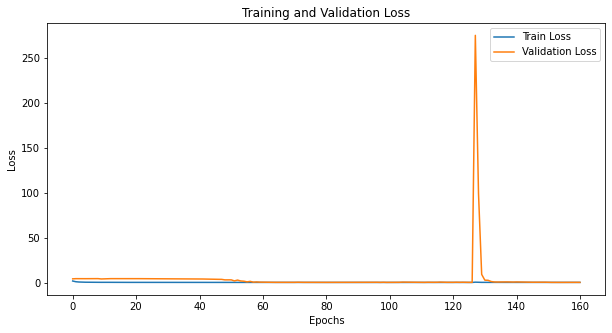

<IPython.core.display.Javascript object>

In [5]:
df_run_1_0 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_5_lead_0_lr_0.005_ep_3000_bs_128_filters24.csv"
)

In [6]:
df_run_1_0

,epoch,loss,val_loss
0,0,1.687831,4.091661
1,1,0.871599,4.290019
2,2,0.563612,4.314513
3,3,0.414710,4.292337
4,4,0.333101,4.257388
...,...,...,...
156,156,0.127107,0.148432
157,157,0.128533,0.136515
158,158,0.127763,0.221043
159,159,0.128272,0.186356


<IPython.core.display.Javascript object>

In [38]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_5_lead_15_lr_0.005_ep_3000_bs_128_filters24.h5",
    5,
    0,
)

12/12 [==============================] - 23s 2s/step


<IPython.core.display.Javascript object>

In [35]:
train_preds, train_scores = train_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_5_lead_15_lr_0.005_ep_3000_bs_128_filters24.h5",
    5,
    0,
)

45/45 [==============================] - 94s 2s/step


<IPython.core.display.Javascript object>

In [40]:
lead_time = 0
train_var_mean = []
train_var_std = []
train_var_y = []
for var in range(6):
    (
        padded_train_data_mean,
        padded_train_data_std,
        padded_train_data_y,
    ) = u_net_load_train_data(var, lead_time)
    train_var_mean.append(padded_train_data_mean)
    train_var_std.append(padded_train_data_std)
    train_var_y.append(padded_train_data_y)

<IPython.core.display.Javascript object>